# 小盘股投资策略，在A股市场的效果一直很好
此处使用惠特尼的小盘股投资策略，长期年化收益率18.3%，远超大盘表现

In [16]:
# 首先import需要使用的第三方库

from jaqs_fxdayu.data import DataView # 可以视为一个轻量级的数据库，数据格式基于pandas，方便数据的调用和处理
from jaqs_fxdayu.data import RemoteDataService # 数据服务，用于下载数据
import os
import warnings
import alphalens
import talib
import pandas as pd
from datetime import datetime
import rqalpha
from rqalpha.api import *

warnings.filterwarnings("ignore")

In [17]:
# 读取需要的因子
dataview_folder = '../Whitney'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


# 开始策略回测

* 在init()部分完成初始化


* 在handle_bar()部分执行交易


* 为避免未来数据，在after_trading()部分才读取因子数据

# Init() 
必要函数

初始化方法 - 在回测和实时模拟交易只会在启动的时候触发一次。你的算法会使用这个方法来设置你需要的各种初始化配置。 context 对象将会在你的算法的所有其他的方法之间进行传递以方便你可以拿取到。

参数：
* context (StrategyContext object) – 策略上下文

In [5]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # 在context中保存全局变量
    context.stocks = dv.symbol
    
    # 每次选股数量
    context.holding_num = 50

    # 今日目标交易股票
    context.target_stocks = []

# handle_bar()
必要函数

bar数据的更新会自动触发该方法的调用。策略具体逻辑可在该方法内实现，包括交易信号的产生、订单的创建等。在实时模拟交易中，该函数在交易时间内会每分钟被触发一次。

参数:	
* context (StrategyContext object) – 策略上下文


* bar_dict (BarDict object) – key为order_book_id，value为bar数据。当前合约池内所有合约的bar数据信息都会更新在bar_dict里面



In [22]:
def handle_bar(context, bar_dict):   
    
    # 读取现在仓位
    cur_holdings = context.portfolio.positions.keys()
    
    # 计算需要卖出的仓位
    sell_positions = list(set(cur_holdings) - set(context.target_stocks))
    
#     # 调用交易函数，卖出
#     for i in range(0,len(sell_positions)):
#         order_target_value(sell_positions[i], 0)
    
    # 买入股票
    # 每只股票等金额买入
    
    
    
    # 计算持有的总权益
    total_value = context.portfolio.total_value
    # 计算每只股票应持有仓位
    every_value = total_value / context.holding_num
    # 计算需要买入的股票
    buy_positions = list(set(context.target_stocks) - set(cur_holdings))
    
    # 交易
    for i in range(0,len(cur_holdings)):
        order_target_value(cur_holdings[i], every_value)
        
    for i in range(0,len(buy_positions)):
        order_target_value(buy_positions[i], every_value)

    #logger.info(buy_positions)

# after_trading()
非必要函数

每天在收盘后被调用。不能在这个函数中发送订单。您可以在该函数中进行当日收盘后的一些计算。在实时模拟交易中，该函数会在每天15:30触发。

参数:	
* context (StrategyContext object) – 策略上下文

In [34]:
def after_trading(context):
    
    # 获得当天日期
    year = str(context.now.year)
    mon = str(context.now.month)
    day = str(context.now.day)
    if len(mon)<2:
        mon = '0'+mon
    if len(day)<2:
        day = '0'+day
        
    today = year+mon+day

    # 读取因子数据
    factors = dv.get_snapshot(int(today), fields='Whitney')
    factors.fillna(0)
    
    # 满足条件数量
    score = 5
    #score = int(factors.max())
    
    # 按条件选股
    target = factors.loc[factors['Whitney']>=score]
    context.target_stocks = list(target.index)
    
    # 替换股票代码格式　.SZ -> XSHE   .SH -> XSHG
    for i in range(0,len(context.target_stocks)):
        context.target_stocks[i] = context.target_stocks[i].replace('.SZ','.XSHE')
        context.target_stocks[i] = context.target_stocks[i].replace('.SH','.XSHG')
    
 

# 配置Config，实现交易

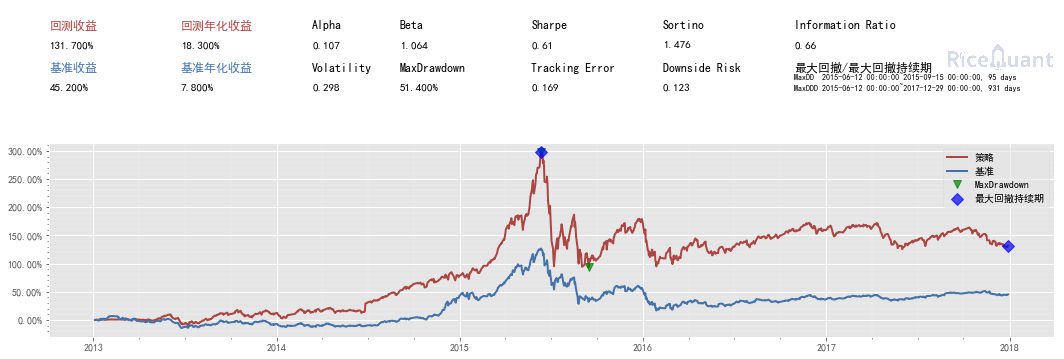

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2013-01-04',
   'end_date': '2017-12-29',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.XSHG',
   'STOCK': 1000000.0,
   'alpha': 0.107,
   'beta': 1.064,
   'sharpe': 0.61,
   'information_ratio': 0.66,
   'downside_risk': 0.123,
   'tracking_error': 0.169,
   'sortino': 1.476,
   'volatility': 0.298,
   'max_drawdown': 0.514,
   'total_value': 2316884.296,
   'cash': 468.906,
   'total_returns': 1.317,
   'annualized_returns': 0.183,
   'unit_net_value': 2.317,
   'units': 1000000.0,
   'benchmark_total_returns': 0.452,
   'benchmark_annualized_returns': 0.078},
  'trades':                      commission         exec_id  last_price  last_quantity  \
  datetime                                                                     
  2013-01-07 15:00:00     15.8912  15339723901272        3.82           5200   
  2013-01-07 15:00:00     15.8880  15339723901273        6.62 

In [35]:
config = {
  "base": {
    "start_date": "2013-01-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar,after_trading=after_trading ,config=config)